In [1]:
import h5py

filename = "D:/VG-SGG-with-attri.h5"

h5 = h5py.File(filename,'r')

In [ ]:
import pan

In [5]:
list(h5.keys())

['active_object_mask',
 'attributes',
 'boxes_1024',
 'boxes_512',
 'img_to_first_box',
 'img_to_first_rel',
 'img_to_last_box',
 'img_to_last_rel',
 'labels',
 'predicates',
 'relationships',
 'split']

In [17]:
h5['img_to_last_rel'].shape

(108073,)

In [18]:
h5['img_to_last_rel'][0]

28

In [8]:
h5['relationships'].shape

(622705, 2)

In [11]:
h5['boxes_512'].shape

(1145398, 4)

In [12]:
h5['boxes_512'][10]

array([260, 220,  53,  64])

In [1]:
from transformers import AutoTokenizer, TextStreamer
from transformers import AutoModelForSeq2SeqLM
import time
import torch

device = torch.device("cuda")

tokenizer = AutoTokenizer.from_pretrained("lizhuang144/flan-t5-base-VG-factual-sg", trust_remote_code=True)
model = AutoModelForSeq2SeqLM.from_pretrained("lizhuang144/flan-t5-base-VG-factual-sg").to(device)

C:\Users\takhu\anaconda3\envs\crawl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\takhu\anaconda3\envs\crawl\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\takhu\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this articl

In [13]:
start = time.time()
text = tokenizer(
    "a boy and a girl holding hands while sitting on a shore.",
    max_length=200,
    return_tensors="pt",
    truncation=True
).to(device)


generated_ids = model.generate(
    text["input_ids"],
    attention_mask=text["attention_mask"],
    use_cache=True,
    decoder_start_token_id=tokenizer.pad_token_id,
    num_beams=1,
    max_length=200,
    early_stopping=True
)
end = time.time()
print(end-start)
output = tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
print(output)

1.0162291526794434
( boy, hold, hands ), ( girl, hold, hands ), ( boy, sit on, shore ), ( girl, sit on, shore ), ( girl, sit on, shore ), ( boy, hold, hands ), ( girl, sit on, shore )


In [1]:
from Controller_GCN import Trainer, Evaluator
import torch
import os
import joblib
import json

info_dict = dict()
info_dict['numb_sample'] = None # training sample for 1 epoch
info_dict['numb_epoch'] = 100 # number of epoch
info_dict['numb_gcn_layers'] = 1 # number of gin layers to be stacked
info_dict['gcn_hidden_dim'] = [] # hidden layer in each gin layer
info_dict['gcn_output_dim'] = 1024
info_dict['gcn_input_dim'] = 2048
info_dict['batchnorm'] = True
info_dict['batch_size'] = 128
info_dict['dropout'] = 0.5
info_dict['visual_backbone'] = 'b5' # 'b0' or 'b4'
info_dict['visual_ft_dim'] = 2048
#info_dict['save_dir'] = '/home/hong01/Research/GraSim/Report'
info_dict['save_dir'] = '/home/nmduy/Graphs/GraSim/Report'
info_dict['optimizer'] = 'Adam' # or Adam
info_dict['learning_rate'] = 3e-4
info_dict['activate_fn'] = 'swish' # swish, relu, leakyrelu
info_dict['grad_clip'] = 2 # Gradient clipping
# info_dict['use_residual'] = False # always set it to false
# Embedder for each objects and predicates, embed graph only base on objects
info_dict['model_name'] = 'GCN_ObjAndPredShare_NoFtExModule_LSTM_i2t' 
info_dict['checkpoint'] = None #'/home/nmduy/Graphs/GraSim/Report/GCN_ObjAndPredShare_NoFtExModule_LSTM-15022021-014523.pth.tar'
info_dict['margin_matrix_loss'] = 0.35
info_dict['rnn_numb_layers'] = 2
info_dict['rnn_bidirectional'] = True
info_dict['rnn_structure'] = 'LSTM'
info_dict['graph_emb_dim'] = info_dict['gcn_output_dim']*2
info_dict['include_pred_ft'] = True # include visual predicate features or not
info_dict['freeze'] = False

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
info_dict['checkpoint'] = '/home/nmduy/Graphs/GraSim/Report/GCN_ObjAndPredShare_NoFtExModule_LSTM_Freeze-16022021-030527.pth.tar'

evaluator = Evaluator(info_dict)
evaluator.load_trained_model()

subset = 'test'
DATA_DIR = '/home/nmduy/Graphs/GraSim/OriginalData'
DATA_IMG_DIR = '/home/nmduy/Graphs/GraSim/OriginalData'
images_data = joblib.load(f"{DATA_IMG_DIR}/flickr30k_{subset}_lowered_images_data.joblib")
caps_data = joblib.load(f"{DATA_DIR}/flickr30k_{subset}_lowered_caps_data.joblib")

#     lossVal, ar_val, ari_val = evaluator.validate_retrieval(images_data, caps_data, False)
#     info_txt = f"\n----- SUMMARY (Matrix)-----\nLoss Val: {6-lossVal}"   
#     info_txt = info_txt + f"\n[i2t] {round(ar_val[0], 4)} {round(ar_val[1], 4)} {round(ar_val[2], 4)}"
#     info_txt = info_txt + f"\n[t2i] {round(ari_val[0], 4)} {round(ari_val[1], 4)} {round(ari_val[2], 4)}"
#     print(info_txt)

lossVal, ar_val, ari_val = evaluator.validate_retrieval(images_data, caps_data, True, 't2i')
info_txt = f"\n----- SUMMARY (Combine)-----\nLoss Val: {6-lossVal}"   
info_txt = info_txt + f"\n[i2t] {round(ar_val[0], 4)} {round(ar_val[1], 4)} {round(ar_val[2], 4)}"
info_txt = info_txt + f"\n[t2i] {round(ari_val[0], 4)} {round(ari_val[1], 4)} {round(ari_val[2], 4)}"
print(info_txt)

Initilised with given init_weight
Initilised with given init_weight
Initilised with given init_weight
LOAD PRETRAINED MODEL AT /home/nmduy/Graphs/GraSim/Report/GCN_ObjAndPredShare_NoFtExModule_LSTM_Freeze-16022021-030527.pth.tar


In [4]:
lossVal, ar_val, ari_val, result = evaluator.validate_retrieval_result(images_data, caps_data, True, 't2i')
info_txt = f"\n----- SUMMARY (Combine)-----\nLoss Val: {6-lossVal}"   
info_txt = info_txt + f"\n[i2t] {round(ar_val[0], 4)} {round(ar_val[1], 4)} {round(ar_val[2], 4)}"
info_txt = info_txt + f"\n[t2i] {round(ari_val[0], 4)} {round(ari_val[1], 4)} {round(ari_val[2], 4)}"
print(info_txt)

---------- VALIDATE RETRIEVAL RESULT ----------
Embedding objects and predicates of images ...
Embedding captions data ...
Scoring ...
Contrastive Score ...
GraphEmb Score ...
rsum: 4.9074
Average i2t Recall: 0.8633
Image to text: 0.7100 0.9190 0.9610 1.0000 2.9940
Average t2i Recall: 0.7725
Text to image: 0.5744 0.8414 0.9016 1.0000 6.6648

----- SUMMARY (Combine)-----
Loss Val: 1.0926
[i2t] 0.71 0.919 0.961
[t2i] 0.5744 0.8414 0.9016


In [8]:
result['i2t'][0:5] # ranks is the ranks of the ground truth in the prediction --> if pred is good, all of them should in in 0 - 4

[{'id': 0,
  'top5': [2, 4, 1644, 1642, 0],
  'top1': 2,
  'top10': [2, 4, 1644, 1642, 0, 1, 3848, 3911, 3, 1641],
  'ranks': [(0, 4), (1, 5), (2, 0), (3, 8), (4, 1)],
  'is_top1': 1,
  'is_top5': 1},
 {'id': 1,
  'top5': [5, 6, 8, 944, 1409],
  'top1': 5,
  'top10': [5, 6, 8, 944, 1409, 3812, 7, 1408, 1170, 1350],
  'ranks': [(5, 0), (6, 1), (7, 6), (8, 2), (9, 23)],
  'is_top1': 1,
  'is_top5': 1},
 {'id': 2,
  'top5': [2660, 4529, 13, 2233, 2662],
  'top1': 2660,
  'top10': [2660, 4529, 13, 2233, 2662, 1471, 477, 2929, 4633, 14],
  'ranks': [(10, 26), (11, 18), (12, 33), (13, 2), (14, 9)],
  'is_top1': 0,
  'is_top5': 1},
 {'id': 3,
  'top5': [17, 16, 18, 524, 15],
  'top1': 17,
  'top10': [17, 16, 18, 524, 15, 31, 30, 522, 520, 3392],
  'ranks': [(15, 4), (16, 1), (17, 0), (18, 2), (19, 11)],
  'is_top1': 1,
  'is_top5': 1},
 {'id': 4,
  'top5': [22, 23, 20, 24, 21],
  'top1': 22,
  'top10': [22, 23, 20, 24, 21, 1309, 44, 1097, 220, 4374],
  'ranks': [(20, 2), (21, 4), (22, 0), (23

In [62]:
result['t2i'][120:125]

[{'id': 120,
  'top5': [24, 707, 602, 798, 192],
  'top10': [24, 707, 602, 798, 192, 336, 242, 834, 768, 710],
  'top1': 24,
  'is_top1': 1,
  'is_top5': 1,
  'ranks': [(24, 0.0)]},
 {'id': 121,
  'top5': [24, 653, 831, 921, 261],
  'top10': [24, 653, 831, 921, 261, 602, 192, 798, 582, 841],
  'top1': 24,
  'is_top1': 1,
  'is_top5': 1,
  'ranks': [(24, 0.0)]},
 {'id': 122,
  'top5': [24, 707, 831, 159, 923],
  'top10': [24, 707, 831, 159, 923, 226, 809, 528, 599, 964],
  'top1': 24,
  'is_top1': 1,
  'is_top5': 1,
  'ranks': [(24, 0.0)]},
 {'id': 123,
  'top5': [24, 707, 670, 395, 269],
  'top10': [24, 707, 670, 395, 269, 599, 261, 602, 21, 69],
  'top1': 24,
  'is_top1': 1,
  'is_top5': 1,
  'ranks': [(24, 0.0)]},
 {'id': 124,
  'top5': [24, 602, 831, 707, 164],
  'top10': [24, 602, 831, 707, 164, 192, 921, 261, 187, 841],
  'top1': 24,
  'is_top1': 1,
  'is_top5': 1,
  'ranks': [(24, 0.0)]}]

In [42]:
image_caption_matching = joblib.load('/home/nmduy/Graphs/GraSim/Data/image_caption_matching_flickr_test.joblib')
caption_image_matching = joblib.load('/home/nmduy/Graphs/GraSim/Data/caption_image_matching_flickr_test.joblib')
list_id_image = list(image_caption_matching.keys())
list_id_caption = list(caption_image_matching.keys())
caption_json = '/home/nmduy/Graphs/SGM_WACV2020_pretrained/dataset/Flickr30k/flickr30k_test_caps_with_rel.json'
with open(caption_json) as f:
    caption_json = json.load(f)
caption_sentid = {}
for idx in range(len(caption_json)):
    c = caption_json[idx]['captions']
    for idx_c in range(len(c)):
        sid = str(c[idx_c]['sentid'])
        t = c[idx_c]['sent']
        caption_sentid[sid] = t

In [21]:
image_caption_matching['1007129816.jpg']

['125', '126', '127', '128', '129']

In [25]:
caption_image_matching['125']

'1007129816.jpg'

In [28]:
list_id_image[3], list_id_image[4]

('102617084.jpg', '10287332.jpg')

# Zip folder

In [3]:
import shutil

In [4]:
shutil.make_archive("test_100", "zip", "./Data/test_100/")

'D:\\Code\\LGSGM---CheapFake\\test_100.zip'

In [1]:
!zip -r folder_name.zip /Data/test_100

'zip' is not recognized as an internal or external command,
operable program or batch file.


# Test example

In [1]:
import joblib
import pandas as pd

In [2]:
test_frame = pd.read_csv("Data/test/label_file_test.csv")

In [3]:
test_frame.loc[441]

image_name       441.jpg
caption_id           441
context_label          0
Name: 441, dtype: object

In [4]:
test_visual = joblib.load("Data/test/cheapfake_test_lowered_images_data.joblib")
test_textual = joblib.load("Data/test/cheapfake_test_lowered_caps_data.joblib")

In [12]:
test_textual[441]

{'sent': ['Run to the hills: Bobby McKelvie and her "wee dog Nettle" in the Pentlands.',
  'Bobby McKelvie and dog Nettles'],
 'rels': [[['dog', 'is', 'wee'],
   ['person', 'run with', 'dog'],
   ['dog', 'in', 'org'],
   ['person', 'unto', 'hills']],
  [['dog', 'is', 'person'],
   ['dog', 'is', 'nettles'],
   ['person', 'with', 'dog'],
   ['person', 'with', 'nettles']]]}

In [5]:
joblib.dump(test_textual[441], "C:\\Users\\takhu\\OneDrive\\Documents\\Personal\\Research\\scene_graph_example\\caption_example.joblib")

['C:\\Users\\takhu\\OneDrive\\Documents\\Personal\\Research\\scene_graph_example\\caption_example.joblib']

In [6]:
visual_sample = test_visual['441.jpg']

In [7]:
joblib.dump(visual_sample, "C:\\Users\\takhu\\OneDrive\\Documents\\Personal\\Research\\scene_graph_example\\image_example.joblib")

['C:\\Users\\takhu\\OneDrive\\Documents\\Personal\\Research\\scene_graph_example\\image_example.joblib']

In [8]:
visual_sample

{'labels': ['nose',
  'jacket',
  'girl',
  'nose',
  'logo',
  'woman',
  'dog',
  'glass',
  'face',
  'hat',
  'hat',
  'eye',
  'mouth',
  'head',
  'coat',
  'hand',
  'head',
  'jacket',
  'girl',
  'hair',
  'finger',
  'logo',
  'person',
  'arm',
  'coat',
  'face',
  'cap',
  'finger',
  'glove',
  'girl'],
 'bbox': [[111.25, 378.75, 158.75, 419.75],
  [173.75, 372.75, 597.0, 790.0],
  [181.25, 117.3125, 599.0, 788.5],
  [373.75, 287.0, 435.75, 365.5],
  [408.5, 148.25, 476.5, 209.5],
  [171.625, 134.375, 591.0, 744.5],
  [18.0, 219.25, 343.0, 762.0],
  [313.75, 250.375, 516.5, 363.75],
  [312.75, 222.625, 500.25, 455.25],
  [288.0, 94.0625, 558.0, 373.75],
  [88.0625, 169.625, 285.75, 353.5],
  [174.375, 300.25, 215.375, 331.75],
  [346.75, 370.75, 438.25, 419.25],
  [291.25, 84.5, 546.0, 473.5],
  [42.8125, 397.25, 552.5, 770.0],
  [144.125, 484.0, 274.0, 621.0],
  [73.25, 234.25, 292.25, 468.75],
  [1.7255859375, 555.5, 248.75, 775.5],
  [16.09375, 110.625, 431.0, 695.0],


In [9]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))

def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)

    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)


    info = str(i) + '_' + box_labels[i]
    draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)

    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

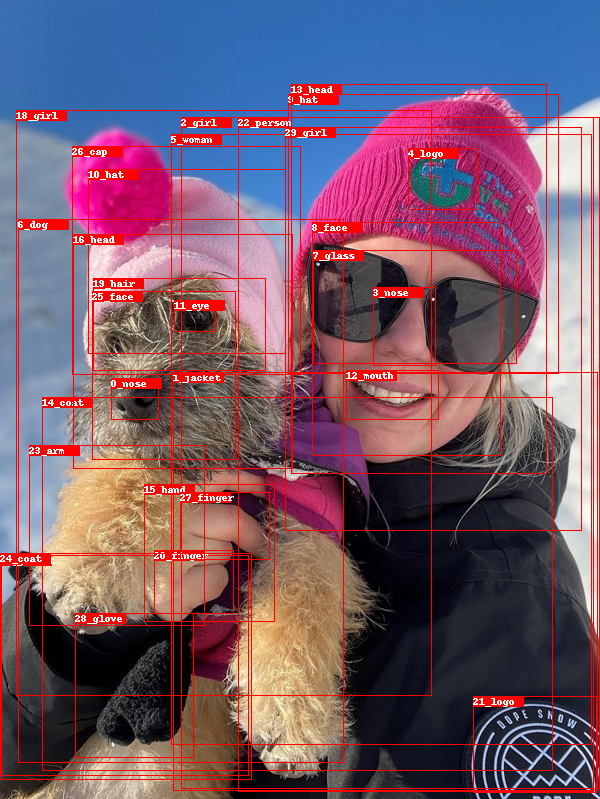

**************************************************
box_labels 0: nose
box_labels 1: jacket
box_labels 2: girl
box_labels 3: nose
box_labels 4: logo
box_labels 5: woman
box_labels 6: dog
box_labels 7: glass
box_labels 8: face
box_labels 9: hat
box_labels 10: hat
box_labels 11: eye
box_labels 12: mouth
box_labels 13: head
box_labels 14: coat
box_labels 15: hand
box_labels 16: head
box_labels 17: jacket
box_labels 18: girl
box_labels 19: hair
box_labels 20: finger
box_labels 21: logo
box_labels 22: person
box_labels 23: arm
box_labels 24: coat
box_labels 25: face
box_labels 26: cap
box_labels 27: finger
box_labels 28: glove
box_labels 29: girl
**************************************************
rel_labels 0: ['girl:2', 'wearing', 'hat:9']
rel_labels 1: ['logo:4', 'on', 'hat:9']
rel_labels 2: ['girl:18', 'wearing', 'cap:26']
rel_labels 3: ['person:22', 'wearing', 'hat:9']
rel_labels 4: ['woman:5', 'wearing', 'hat:9']
rel_labels 5: ['girl:2', 'wearing', 'glass:7']
rel_labels 6: ['glass:7', '

In [11]:
import ast
image_path = "441.jpg"
boxes = visual_sample['bbox']
box_labels = visual_sample['labels']
rel_labels = visual_sample['rels']

draw_image(image_path, boxes, box_labels, rel_labels)

# PLOT IMAGE

In [30]:
from PIL import Image
import json
import joblib

image_dir = '/home/nmduy/flickr30k_images/flickr30k_images'

In [34]:
idx_img = 3
image_path = f"{image_dir}/{list_id_image[idx_img]}"
image = Image.open(image_path)

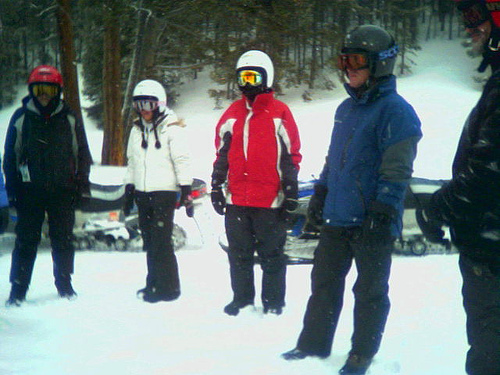

In [35]:
image

In [39]:
result_i2t = result['i2t'][idx_img]
top_retrieval = result_i2t['top5']
captions_id = [list_id_caption[x] for x in top_retrieval]
result_i2t

{'id': 3,
 'top5': [17, 16, 18, 524, 15],
 'top1': 17,
 'top10': [17, 16, 18, 524, 15, 31, 30, 522, 520, 3392],
 'ranks': [(15, 4), (16, 1), (17, 0), (18, 2), (19, 11)],
 'is_top1': 1,
 'is_top5': 1}

In [45]:
captions_id

['447', '446', '448', '14534', '445']

In [53]:
[caption_sentid[x] for x in captions_id]

['Five people wearing winter clothing, helmets, and ski goggles stand outside in the snow.',
 'Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.',
 'A group of snowmobile riders gather in the snow.',
 'A group of people are climbing in cold weather.',
 'Five snowmobile riders all wearing helmets and goggles line up in a snowy clearing in a forest in front of their snowmobiles; they are all wearing black snow pants and from left to right they are wearing a black coat, white coat, red coat, blue coat, and black coat.']

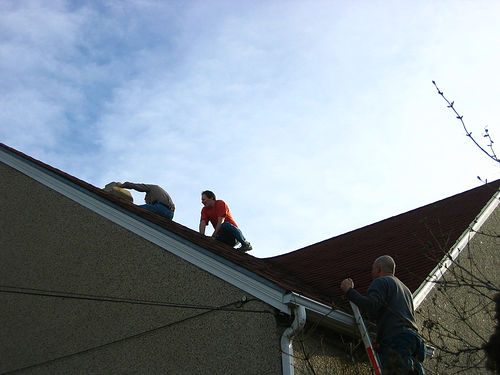

In [54]:
idx_img = 4
image_path = f"{image_dir}/{list_id_image[idx_img]}"
image = Image.open(image_path)
image

In [55]:
result_i2t = result['i2t'][idx_img]
top_retrieval = result_i2t['top5']
captions_id = [list_id_caption[x] for x in top_retrieval]
result_i2t

{'id': 4,
 'top5': [22, 23, 20, 24, 21],
 'top1': 22,
 'top10': [22, 23, 20, 24, 21, 1309, 44, 1097, 220, 4374],
 'ranks': [(20, 2), (21, 4), (22, 0), (23, 1), (24, 3)],
 'is_top1': 1,
 'is_top5': 1}

In [56]:
[caption_sentid[x] for x in captions_id]

['Three men, one on a ladder, work on a roof.',
 'People are fixing the roof of a house.',
 'Two men sitting on the roof of a house while another one stands on a ladder.',
 'Three men are working on a roof.',
 'Two men on a rooftop while another man stands atop a ladder watching them']

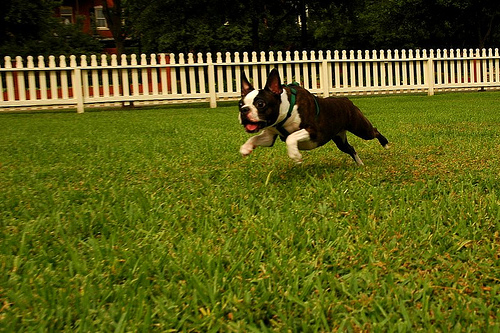

In [59]:
idx_img = 1
image_path = f"{image_dir}/{list_id_image[idx_img]}"
image = Image.open(image_path)
image

In [60]:
result_i2t = result['i2t'][idx_img]
top_retrieval = result_i2t['top5']
captions_id = [list_id_caption[x] for x in top_retrieval]
[caption_sentid[x] for x in captions_id]

['A black and white dog is running in a grassy garden surrounded by a white fence.',
 'A Boston Terrier is running on lush green grass in front of a white fence.',
 'A dog runs on the green grass near a wooden fence.',
 'A dog running though a grassy field.',
 'Two dogs jump for a ball on a green field.']

# Text to Img

In [164]:
idx = 722 #1020
id_captions = list_id_caption[idx]
print(f'ID CAP: {id_captions}')
result_t2i = result['t2i'][idx]
id_imgs = result_t2i['top5']
result_t2i

ID CAP: 22507


{'id': 722,
 'top5': [144, 76, 25, 15, 899],
 'top10': [144, 76, 25, 15, 899, 273, 217, 775, 688, 134],
 'top1': 144,
 'is_top1': 1,
 'is_top5': 1,
 'ranks': [(144, 0.0)]}

In [165]:
caption = caption_sentid[id_captions]
caption

'Little Girl in brown shirt and blue jean skirt dances on wood floor.'

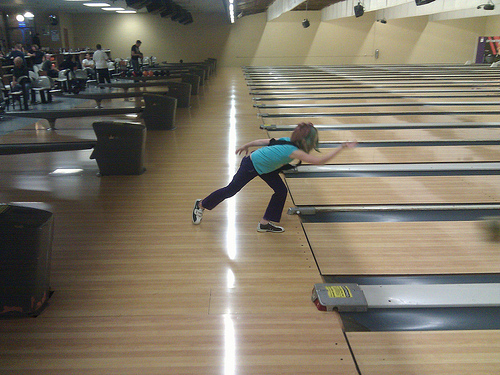

In [170]:
image_path = f"{image_dir}/{list_id_image[id_imgs[4]]}"
image = Image.open(image_path)
image

# Check result

In [1]:
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
result_1 = pd.read_csv("Predict_vs_true.csv")

In [3]:
result_2 = pd.read_csv("Predict_vs_true_70000.csv")

In [3]:
result_3 = pd.read_csv("Predict_vs_true_80000.csv")

In [4]:
print(classification_report(result_3["predict"], result_3["true"]))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       472
           1       0.83      0.79      0.81       528

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



In [5]:
print(classification_report(result["predict"], result["true"]))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       538
           1       0.77      0.83      0.80       462

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



In [3]:
print(classification_report(result["predict"], result["TRUE"]))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       513
           1       0.73      0.75      0.74       487

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



In [4]:
result[result['EQUAL']==False]

Unnamed: 0  predict_percent  predict  TRUE  EQUAL
4             4         0.855336        1     0  False
6             6         0.207889        0     1  False
7             7         0.258285        0     1  False
9             9         0.690711        1     0  False
13           13         0.655925        1     0  False
..          ...              ...      ...   ...    ...
978         978         0.561957        1     0  False
979         979         0.830185        1     0  False
985         985         0.889800        1     0  False
993         993         0.772972        1     0  False
996         996         0.660208        1     0  False

[261 rows x 5 columns]

In [6]:
(result.loc[:, 'predict'] == 0) & (result.loc[:, 'true'] == 1)

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [16]:
result_1[(result_1.loc[:, 'predict'] == 0) & (result_1.loc[:, 'true'] == 1) & (result_3.loc[:, 'predict'] == 0) & (result_3.loc[:, 'true'] == 1)]

Unnamed: 0  predict_percent  predict  true
23           23         0.310068        0   1.0
82           82         0.290561        0   1.0
94           94         0.411362        0   1.0
123         123         0.476279        0   1.0
128         128         0.347034        0   1.0
164         164         0.311287        0   1.0
192         192         0.063553        0   1.0
199         199         0.385710        0   1.0
200         200         0.123684        0   1.0
204         204         0.490955        0   1.0
225         225         0.383080        0   1.0
264         264         0.091301        0   1.0
303         303         0.391492        0   1.0
309         309         0.299139        0   1.0
331         331         0.263074        0   1.0
347         347         0.314425        0   1.0
366         366         0.254544        0   1.0
368         368         0.253423        0   1.0
378         378         0.301331        0   1.0
394         394         0.447539        0   1.0
402         402         0.466792        0   1.0
406         406         0.435852        0   1.0
408         408         0.095016        0   1.0
415         415         0.289228        0   1.0
425         425         0.166667        0   1.0
443         443         0.350859        0   1.0
447         447         0.390329        0   1.0
494         494         0.193946        0   1.0
510         510         0.195747        0   1.0
511         511         0.325717        0   1.0
513         513         0.342959        0   1.0
526         526         0.179091        0   1.0
528         528         0.390831        0   1.0
530         530         0.391492        0   1.0
539         539         0.325717        0   1.0
541         541         0.253423        0   1.0
556         556         0.431975        0   1.0
558         558         0.280602        0   1.0
559         559         0.178995        0   1.0
582         582         0.346669        0   1.0
594         594         0.296715        0   1.0
621         621         0.344599        0   1.0
637         637         0.116751        0   1.0
673         673         0.408900        0   1.0
692         692         0.427203        0   1.0
713         713         0.491818        0   1.0
719         719         0.310528        0   1.0
735         735         0.287608        0   1.0
780         780         0.193520        0   1.0
791         791         0.019133        0   1.0
833         833         0.071101        0   1.0
859         859         0.193946        0   1.0
871         871         0.150767        0   1.0
902         902         0.414904        0   1.0
916         916         0.316243        0   1.0
926         926         0.326720        0   1.0
947         947         0.487032        0   1.0
954         954         0.491818        0   1.0
970         970         0.385710        0   1.0
971         971         0.296933        0   1.0

In [53]:
result_1[(result_1.loc[:, 'predict'] == 0) & (result_1.loc[:, 'true'] == 1) & (result_2.loc[:, 'predict'] == 0) & (result_2.loc[:, 'true'] == 1)][40:60]

Unnamed: 0  predict_percent  predict  true
425         425         0.166667        0   1.0
428         428         0.352213        0   1.0
442         442         0.377646        0   1.0
443         443         0.350859        0   1.0
447         447         0.390329        0   1.0
479         479         0.378107        0   1.0
494         494         0.193946        0   1.0
510         510         0.195747        0   1.0
511         511         0.325717        0   1.0
513         513         0.342959        0   1.0
526         526         0.179091        0   1.0
528         528         0.390831        0   1.0
530         530         0.391492        0   1.0
539         539         0.325717        0   1.0
541         541         0.253423        0   1.0
556         556         0.431975        0   1.0
558         558         0.280602        0   1.0
559         559         0.178995        0   1.0
582         582         0.346669        0   1.0
583         583         0.451759        0   1.0

In [8]:
false_negative = result[(result.loc[:, 'predict'] == 0) & (result.loc[:, 'true'] == 1)]

In [4]:
false_negative = result_3[(result_3.loc[:, 'predict'] == 0) & (result_3.loc[:, 'true'] == 1)]

In [5]:
false_negative

Unnamed: 0  predict_percent  predict  true
23           23         0.136081        0   1.0
82           82         0.461833        0   1.0
93           93         0.398819        0   1.0
94           94         0.494922        0   1.0
123         123         0.276789        0   1.0
..          ...              ...      ...   ...
926         926         0.151319        0   1.0
947         947         0.497600        0   1.0
954         954         0.359098        0   1.0
970         970         0.458557        0   1.0
971         971         0.416582        0   1.0

[83 rows x 4 columns]

In [21]:
result_1[(result_1.loc[:, 'predict'] == 1) & (result_1.loc[:, 'true'] == 0) & (result_3.loc[:, 'predict'] == 1) & (result_3.loc[:, 'true'] == 0)][20:30]

Unnamed: 0  predict_percent  predict  true
467         467         0.553381        1   0.0
473         473         0.537848        1   0.0
498         498         0.526708        1   0.0
504         504         0.512056        1   0.0
523         523         0.553141        1   0.0
529         529         0.579808        1   0.0
545         545         0.602534        1   0.0
592         592         0.587475        1   0.0
599         599         0.939329        1   0.0
619         619         0.613433        1   0.0

In [4]:
result_1[(result_1.loc[:, 'predict'] == 1) & (result_1.loc[:, 'true'] == 0) & (result_2.loc[:, 'predict'] == 1) & (result_2.loc[:, 'true'] == 0)]

Unnamed: 0  predict_percent  predict  true
4             4         0.552154        1   0.0
9             9         0.543082        1   0.0
67           67         0.988594        1   0.0
101         101         0.550634        1   0.0
102         102         0.631158        1   0.0
124         124         0.792998        1   0.0
220         220         0.575638        1   0.0
231         231         0.828477        1   0.0
295         295         0.860095        1   0.0
304         304         0.604052        1   0.0
341         341         0.512061        1   0.0
382         382         0.658023        1   0.0
385         385         0.664154        1   0.0
389         389         0.587939        1   0.0
403         403         0.665982        1   0.0
462         462         0.985447        1   0.0
467         467         0.553381        1   0.0
498         498         0.526708        1   0.0
504         504         0.512056        1   0.0
523         523         0.553141        1   0.0
529         529         0.579808        1   0.0
545         545         0.602534        1   0.0
592         592         0.587475        1   0.0
599         599         0.939329        1   0.0
620         620         0.734328        1   0.0
649         649         0.916385        1   0.0
658         658         0.538160        1   0.0
685         685         0.835566        1   0.0
690         690         0.546076        1   0.0
705         705         0.888759        1   0.0
730         730         0.604296        1   0.0
741         741         0.578997        1   0.0
752         752         0.687431        1   0.0
761         761         0.654118        1   0.0
765         765         0.708268        1   0.0
772         772         0.602568        1   0.0
773         773         0.551326        1   0.0
789         789         0.600809        1   0.0
806         806         0.670251        1   0.0
825         825         0.504539        1   0.0
853         853         0.763084        1   0.0
896         896         0.997394        1   0.0
908         908         0.527773        1   0.0
930         930         0.510815        1   0.0
949         949         0.860287        1   0.0
953         953         0.510633        1   0.0
964         964         0.607075        1   0.0
967         967         0.651177        1   0.0
968         968         0.812329        1   0.0
979         979         0.617307        1   0.0
985         985         0.647430        1   0.0
989         989         0.560560        1   0.0
993         993         0.543886        1   0.0

In [21]:
result[(result.loc[:, 'predict'] == 1) & (result.loc[:, 'true'] == 0)]

Unnamed: 0  predict_percent  predict  true
4             4         0.552154        1   0.0
9             9         0.543082        1   0.0
65           65         0.559817        1   0.0
67           67         0.988594        1   0.0
101         101         0.550634        1   0.0
..          ...              ...      ...   ...
979         979         0.617307        1   0.0
985         985         0.647430        1   0.0
989         989         0.560560        1   0.0
993         993         0.543886        1   0.0
997         997         0.757783        1   0.0

[77 rows x 4 columns]

In [33]:
result_1.loc[896]

Unnamed: 0         896.000000
predict_percent      0.997394
predict              1.000000
true                 0.000000
Name: 896, dtype: float64

In [1]:
import joblib

In [11]:
from PIL import Image, ImageDraw

In [2]:
test_captions = joblib.load("Data/cheapfake_test_lowered_caps_data.joblib")

In [9]:
def separate_sentence(sentence):
    # split the sentence by the special token [SEP]
    sentence = sentence.replace("[CLS] ", "")
    sentences = sentence.split("[SEP]") 
    # remove the leading and trailing spaces from each sentence
    sentences = [s.strip() for s in sentences]
    # remove the empty sentences
    sentences = [s for s in sentences if s]
    # return the list of sentences
    return sentences

In [10]:
sentence = "[CLS] Julian Castro at his announcement in San Antonio, Tex., on Saturday. Mr. Castro, the former secretary of housing and urban development, would be one of the youngest presidents if elected.[SEP] Julian Castro at his announcement in San Antonio, Tex., on Saturday, Jan. 12, 2019.[SEP]"
output = separate_sentence(sentence)
print(output)

['Julian Castro at his announcement in San Antonio, Tex., on Saturday. Mr. Castro, the former secretary of housing and urban development, would be one of the youngest presidents if elected.', 'Julian Castro at his announcement in San Antonio, Tex., on Saturday, Jan. 12, 2019.']


In [3]:
test_captions

{0: {'sent': '[CLS] Julian Castro at his announcement in San Antonio, Tex., on Saturday. Mr. Castro, the former secretary of housing and urban development, would be one of the youngest presidents if elected.[SEP] Julian Castro at his announcement in San Antonio, Tex., on Saturday, Jan. 12, 2019.[SEP]',
  'rels': [[['announcement', 'in', 'gpe'],
    ['announcement', 'on', 'date'],
    ['secretary', 'of', 'development'],
    ['person', 'at', 'announcement'],
    ['secretary', 'of', 'housing']],
   [['person', 'at', 'announcement'],
    ['announcement', 'in', 'gpe'],
    ['announcement', 'on', 'date']]]},
 1: {'sent': "[CLS] Supporters of Tanzania's ruling Chama Cha Mapinduzi party come out on Friday to celebrate their candidate's victory in the disputed Zanzibari presidential election[SEP] A person sits on a truck as supporters of the ruling Chama Cha Mapinduzi (Revolutionary Party) celebrate the victory of their candidate in the Zanzibar Presidential election on the outskirts of Stone T

In [22]:
from string import printable

In [24]:
test_captions[498]

{'sent': '[CLS] A child in red boots standing in a puddle[SEP] This photograph was taken by Louise Smart during a walk with her sons in Maldon, Essex[SEP]',
 'rels': [[['child', 'in', 'boot'], ['child', 'in', 'puddle']],
  [['person', 'take', 'photograph'],
   ['person', 'during', 'walk'],
   ['walk', 'with', 'son'],
   ['son', 'in', 'gpe']]]}

In [ ]:
["groundless conspiracy theories", "There is no evidence that", "Splicing created a false impression", "is a fabricated one", "unwittingly fooled thousands of people", 

In [120]:
list_fakenews = ["fake", "false", "wrong", "fabricat", "fool", "hoax", "baseless", "unfounded"]

In [121]:
count = 0
for i in false_negative['Unnamed: 0']:
    sentence = test_captions[i]['sent'].lower()
    for word in list_fakenews:
        if word in sentence:
            count += 1
            break

In [122]:
count

36

In [6]:
word2index = joblib.load("Data/cheapfake_lowered_caps_word2idx_train_12000.joblib")

In [34]:
word2index['point']

17

In [41]:
df = pd.read_csv("Data/label_file_test.csv")

In [87]:
df.loc[993]

image_name       993.jpg
caption_id           993
context_label          0
Name: 993, dtype: object

In [8]:
image_data = joblib.load("Data/cheapfake_test_lowered_images_data.joblib")

In [45]:
image_data['4.jpg']

{'labels': ['shirt',
  'man',
  'man',
  'shoe',
  'hand',
  'shirt',
  'people',
  'woman',
  'hand',
  'hair',
  'person',
  'shirt',
  'person',
  'shoe',
  'person',
  'shirt',
  'phone',
  'shirt',
  'man',
  'hand',
  'person',
  'short',
  'shoe',
  'shirt',
  'hand',
  'arm',
  'hand',
  'man',
  'sneaker',
  'leg'],
 'bbox': [[383.0, 52.9375, 643.0, 324.5],
  [20.015625, 66.9375, 285.25, 511.5],
  [786.0, 0.0, 896.0, 551.5],
  [705.0, 222.75, 875.0, 332.75],
  [298.75, 58.71875, 348.75, 145.375],
  [3.25, 20.4375, 65.625, 328.75],
  [0.0, 5.67578125, 896.0, 524.5],
  [637.5, 21.03125, 892.5, 509.5],
  [38.9375, 49.09375, 268.25, 309.25],
  [697.5, 22.109375, 832.5, 197.375],
  [5.921875, 0.0, 82.625, 520.5],
  [846.5, 225.625, 895.5, 326.5],
  [412.5, 5.91796875, 641.5, 502.5],
  [34.90625, 468.0, 84.75, 523.5],
  [22.671875, 7.703125, 329.5, 492.75],
  [424.0, 0.283203125, 612.0, 158.5],
  [314.5, 52.65625, 343.5, 106.5],
  [166.625, 84.3125, 475.0, 329.0],
  [2.306640625, 19

In [3]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

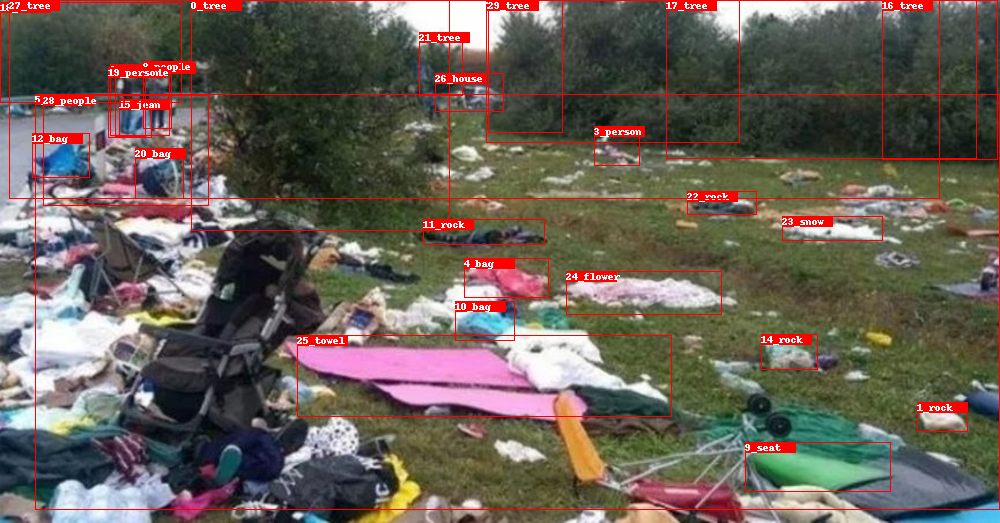

**************************************************
box_labels 0: tree
box_labels 1: rock
box_labels 2: person
box_labels 3: person
box_labels 4: bag
box_labels 5: beach
box_labels 6: people
box_labels 7: tree
box_labels 8: people
box_labels 9: seat
box_labels 10: bag
box_labels 11: rock
box_labels 12: bag
box_labels 13: people
box_labels 14: rock
box_labels 15: jean
box_labels 16: tree
box_labels 17: tree
box_labels 18: tree
box_labels 19: person
box_labels 20: bag
box_labels 21: tree
box_labels 22: rock
box_labels 23: snow
box_labels 24: flower
box_labels 25: towel
box_labels 26: house
box_labels 27: tree
box_labels 28: people
box_labels 29: tree
**************************************************
rel_labels 0: ['person:19', 'wearing', 'jean:15']
rel_labels 1: ['people:8', 'walking on', 'beach:5']
rel_labels 2: ['people:6', 'walking on', 'beach:5']
rel_labels 3: ['person:2', 'walking on', 'beach:5']
rel_labels 4: ['tree:7', 'along', 'beach:5']
rel_labels 5: ['person:19', 'walking on', 

In [13]:
image_path = "D:\\Research Data\\caption_image\\public_test_mmsys\\55.jpg"
boxes = image_data['55.jpg']['bbox']
box_labels = image_data['55.jpg']['labels']
rel_labels = image_data['55.jpg']['rels']
draw_image(image_path, boxes, box_labels, rel_labels)